<a href="https://colab.research.google.com/github/KishanthanKingston/KishanthanKingston/blob/main/Copy_of_Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-h1ig189_
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-h1ig189_
  Resolved https://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


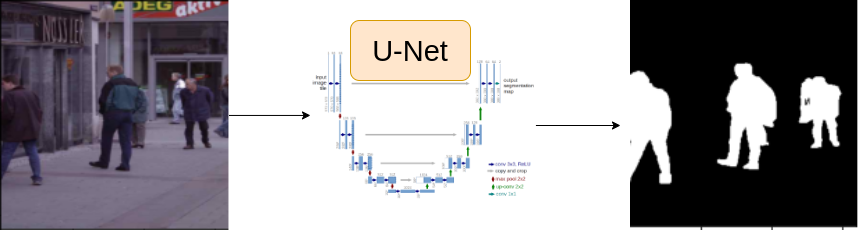

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [68]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [31]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [56]:
row = df.iloc[1]

image_path = row.images
mask_path = row.masks

# Read the file
image = cv2.imread(image_path)
# Images in cv2 are in BGR format, so we change it in RGB format
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0


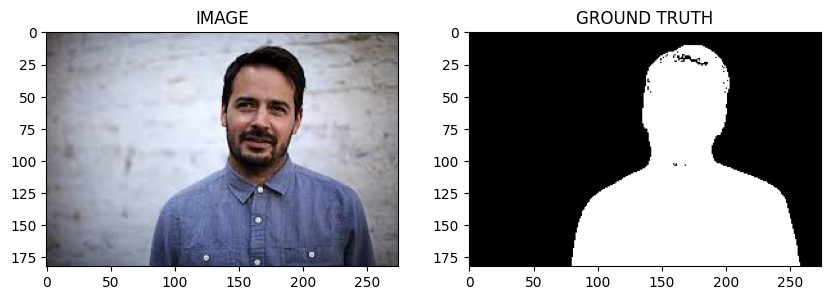

In [57]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [34]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [35]:
import albumentations as A
from albumentations.core.transforms_interface import BasicTransform

In [98]:
"""
def get_train_augs():
  return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE), 
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE) 
])
"""

def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE, always_apply=True),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
    ], additional_targets={'mask': 'image'}, is_check_shapes=False)

def get_valid_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE, always_apply=True)
    ], additional_targets={'mask': 'image'}, is_check_shapes=False)




# Task 4 : Create Custom Dataset 

In [99]:
from torch.utils.data import Dataset

In [100]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h,w,c=1)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

      #(h, w, c) --> (c, h, w)

      image = np.transpose(image, (2, 0, 1)).astype(np.float32)
      mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

      # convert numpy to Tensor

      image = torch.Tensor(image) / 255.0
      mask = torch.round(torch.Tensor(mask) / 255.0)

      return image, mask




In [101]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [102]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


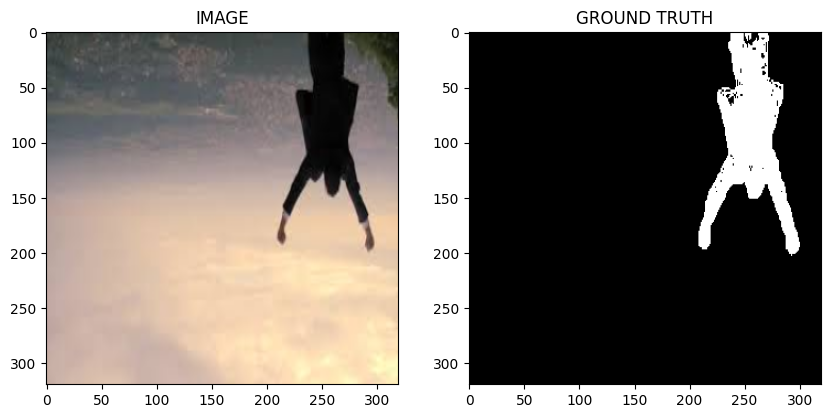

In [103]:
idx = 26

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [104]:
from torch.utils.data import DataLoader

In [105]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [106]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [107]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [127]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
import torch.nn.functional as F

In [128]:

class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      #loss2 = nn.BCEWithLoss()(logits, masks)
      loss2 = F.binary_cross_entropy_with_logits(logits, masks)
      return logits, loss1 + loss2

    return logits

In [129]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function 

In [130]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 00

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss = loss.item()

  return total_loss / len(data_loader)

In [131]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 00

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss = loss.item()

    return total_loss / len(data_loader)

# Task 8 : Train Model

In [132]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [134]:
best_validation_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_validation_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('SAVED-MODEL')
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train_loss : {train_loss} valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  5.32it/s]


SAVED-MODEL
Epoch : 1 Train_loss : 0.036320841312408446 valid_loss : 0.11494693905115128


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


SAVED-MODEL
Epoch : 2 Train_loss : 0.016091883182525635 valid_loss : 0.07619888335466385


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


SAVED-MODEL
Epoch : 3 Train_loss : 0.015928219755490622 valid_loss : 0.14338654279708862


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


SAVED-MODEL
Epoch : 4 Train_loss : 0.016854397455851235 valid_loss : 0.07217918336391449


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


SAVED-MODEL
Epoch : 5 Train_loss : 0.014771307508150736 valid_loss : 0.11283376812934875


100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


SAVED-MODEL
Epoch : 6 Train_loss : 0.01443583369255066 valid_loss : 0.08368220925331116


100%|██████████| 4/4 [00:00<00:00,  5.25it/s]


SAVED-MODEL
Epoch : 7 Train_loss : 0.013991806904474895 valid_loss : 0.06676001101732254


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


SAVED-MODEL
Epoch : 8 Train_loss : 0.012736518184343975 valid_loss : 0.05502626672387123


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


SAVED-MODEL
Epoch : 9 Train_loss : 0.020126483837763467 valid_loss : 0.04693438112735748


100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


SAVED-MODEL
Epoch : 10 Train_loss : 0.010818288723627726 valid_loss : 0.05167844146490097


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


SAVED-MODEL
Epoch : 11 Train_loss : 0.010788078109423319 valid_loss : 0.04662981629371643


100%|██████████| 4/4 [00:00<00:00,  5.17it/s]


SAVED-MODEL
Epoch : 12 Train_loss : 0.010095349947611491 valid_loss : 0.050942014902830124


100%|██████████| 4/4 [00:00<00:00,  5.19it/s]


SAVED-MODEL
Epoch : 13 Train_loss : 0.013836852709452311 valid_loss : 0.06452569365501404


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


SAVED-MODEL
Epoch : 14 Train_loss : 0.015885679920514425 valid_loss : 0.06517554819583893


100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


SAVED-MODEL
Epoch : 15 Train_loss : 0.01908928950627645 valid_loss : 0.07815089821815491


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


SAVED-MODEL
Epoch : 16 Train_loss : 0.017628602186838784 valid_loss : 0.05301186442375183


100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


SAVED-MODEL
Epoch : 17 Train_loss : 0.00766001691420873 valid_loss : 0.0728602260351181


100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


SAVED-MODEL
Epoch : 18 Train_loss : 0.0077033927043279014 valid_loss : 0.05582183972001076


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


SAVED-MODEL
Epoch : 19 Train_loss : 0.007228737572828928 valid_loss : 0.057407427579164505


100%|██████████| 4/4 [00:00<00:00,  5.28it/s]


SAVED-MODEL
Epoch : 20 Train_loss : 0.006730287770430247 valid_loss : 0.05940355733036995


100%|██████████| 4/4 [00:00<00:00,  4.51it/s]


SAVED-MODEL
Epoch : 21 Train_loss : 0.009327965974807739 valid_loss : 0.13278385996818542


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


SAVED-MODEL
Epoch : 22 Train_loss : 0.011921093861262003 valid_loss : 0.08488070964813232


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


SAVED-MODEL
Epoch : 23 Train_loss : 0.009279709060986836 valid_loss : 0.07548022270202637


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


SAVED-MODEL
Epoch : 24 Train_loss : 0.008721755941708882 valid_loss : 0.06968170404434204


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


SAVED-MODEL
Epoch : 25 Train_loss : 0.00544537752866745 valid_loss : 0.1138039231300354


# Task 9 : Inference

In [135]:
idx = 20

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C,H,W) --> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

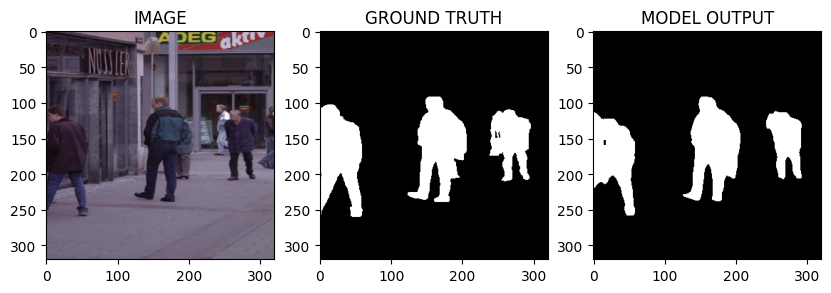

In [137]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya